In [2]:
import numpy as np # handle arrays
import pandas as pd # data wrangling
import matplotlib.pyplot as plt # plots
import seaborn as sns # pretty plots

from scipy.optimize import curve_fit
import warnings

sns.set_theme(style="ticks",font_scale = 1.5,rc={"lines.linewidth": 2.5})

palette = sns.color_palette()

In [3]:
def hillFunc(x, K, h): # Hill sigmoidal equation from zunzun.com
    return np.power(np.log10(x), h) / (np.power(np.log10(K), h) + np.power(np.log10(x), h))

def fitHill(x,y,func=hillFunc,initial_parameters=np.array([500, 10])):
    # these are the same as the scipy defaults

    # do not print unnecessary warnings during curve_fit()
    warnings.filterwarnings("ignore")

    # curve fit the test data
    fitted_parameters, pcov = curve_fit(func, x, y, initial_parameters)

    model_predictions = func(x, *fitted_parameters) 

    abs_error = model_predictions - y

    SE = np.square(abs_error) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(abs_error) / np.var(y))

    print('Parameters:', fitted_parameters)
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)
    
    print(fitted_parameters)
    print('IC50: ',fitted_parameters[0])
    
    return fitted_parameters

In [906]:
dat_full = pd.read_csv('./Pablo PI3K PI4K 7Nov2023/pablo wort Rluc 15sec shake 1sec int 2023.11.07 15_58_32 rm outlier.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

gene_name = 'PI3K'
inducer_concentrations = [0,2]
compound_name = 'Wortmannin'
compound_concentration_max = 100000
compound_rows_no_inducer = ['A','B','C']
compound_rows_inducer = ['D','E','F']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

,ID,SequenceID,WellPosition,ScanPosition,Tag,RLU,RLU(RQ),Timestamp(ms),Row,Column
0,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:1,NaN,NaN,356,ValidSlopeSaturation,1313288525,A,1
1,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:2,NaN,NaN,713,ValidSlopeSaturation,1313289773,A,2
2,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:3,NaN,NaN,455,ValidSlopeSaturation,1313291029,A,3
3,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:4,NaN,NaN,782,ValidSlopeSaturation,1313292298,A,4
4,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:5,NaN,NaN,1357,ValidSlopeSaturation,1313293549,A,5
...,...,...,...,...,...,...,...,...,...,...
91,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,H:8,NaN,NaN,461,ValidSlopeSaturation,1313409925,H,8
92,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,H:9,NaN,NaN,518,ValidSlopeSaturation,1313411179,H,9
93,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,H:10,NaN,NaN,482,ValidSlopeSaturation,1313412433,H,10
94,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,H:11,NaN,NaN,505,ValidSlopeSaturation,1313413693,H,11


In [909]:
dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

,ID,SequenceID,WellPosition,ScanPosition,Tag,RLU,RLU(RQ),Timestamp(ms),Row,Column,Treatment,IPTG_nM,Fraction_growth
0,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:1,NaN,NaN,356,ValidSlopeSaturation,1313288525,A,1,Wortmannin,0,0.000000
1,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:2,NaN,NaN,713,ValidSlopeSaturation,1313289773,A,2,Wortmannin,0,0.103299
2,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:3,NaN,NaN,455,ValidSlopeSaturation,1313291029,A,3,Wortmannin,0,0.028646
3,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:4,NaN,NaN,782,ValidSlopeSaturation,1313292298,A,4,Wortmannin,0,0.123264
4,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,A:5,NaN,NaN,1357,ValidSlopeSaturation,1313293549,A,5,Wortmannin,0,0.289641
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,F:8,NaN,NaN,20670,ValidSlopeSaturation,1313377759,F,8,Wortmannin,2,0.913001
68,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,F:9,NaN,NaN,22610,ValidSlopeSaturation,1313379025,F,9,Wortmannin,2,1.000000
69,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,F:10,NaN,NaN,21110,ValidSlopeSaturation,1313380282,F,10,Wortmannin,2,0.932732
70,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,F:11,NaN,NaN,20220,ValidSlopeSaturation,1313381545,F,11,Wortmannin,2,0.892820


Parameters: [2708.43753986   -8.71437685]
RMSE: 0.04877362151643754
R-squared: 0.98362695435149
[2708.43753986   -8.71437685]
IC50:  2708.4375398586785
Parameters: [8165.32205152  -12.00587973]
RMSE: 0.052341994823197346
R-squared: 0.9846201701918996
[8165.32205152  -12.00587973]
IC50:  8165.322051519654
Parameters: [8165.32205152  -12.00587973]
RMSE: 0.052341994823197346
R-squared: 0.9846201701918996
[8165.32205152  -12.00587973]
IC50:  8165.322051519654
Parameters: [2708.43753986   -8.71437685]
RMSE: 0.04877362151643754
R-squared: 0.98362695435149
[2708.43753986   -8.71437685]
IC50:  2708.4375398586785
IC50 fold change: 3.0147721449562046


(-0.05, 1.05)

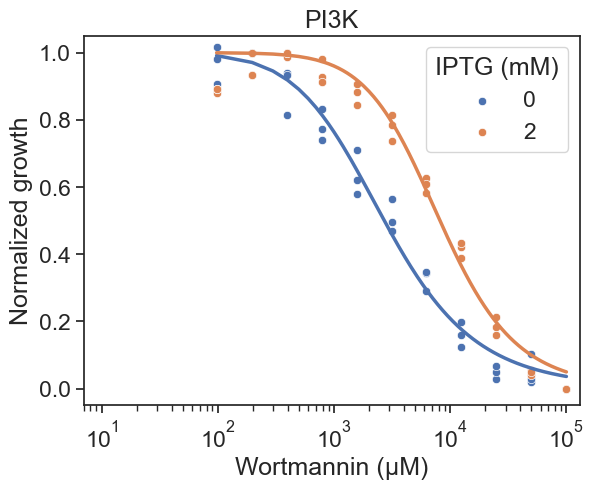

In [913]:
plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[500,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[500,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1)[0] / fitHill(x_compound,y_inducer_0)[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (µM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([7, 130000])
ax.set_ylim([-0.05, 1.05])

Parameters: [1527.44259218  -16.47366451]
RMSE: 0.05981222530628551
R-squared: 0.9816381429993809
[1527.44259218  -16.47366451]
IC50:  1527.4425921770767
Parameters: [2430.2445327   -18.42040374]
RMSE: 0.04603487068769519
R-squared: 0.9913904238665973
[2430.2445327   -18.42040374]
IC50:  2430.244532702384
Parameters: [2430.2445327   -18.42040374]
RMSE: 0.04603487068769519
R-squared: 0.9913904238665973
[2430.2445327   -18.42040374]
IC50:  2430.244532702384
Parameters: [1527.44259218  -16.47366451]
RMSE: 0.05981222530628551
R-squared: 0.9816381429993809
[1527.44259218  -16.47366451]
IC50:  1527.4425921770767
IC50 fold change: 1.5910545804792153


(-0.05, 1.05)

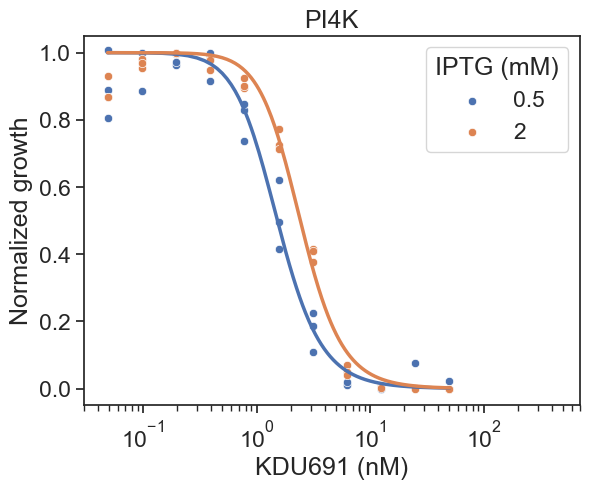

In [905]:
dat_full = pd.read_csv('./Pablo PI3K PI4K 7Nov2023/pablo kdu Rluc 15sec shake 1sec int 2023.11.07 15_53_03 rm outlier.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

gene_name = 'PI4K'
inducer_concentrations = [ 0.5,2 ]
compound_name = 'KDU691'
compound_concentration_max = 50000
compound_rows_no_inducer = ['A','B','C']
compound_rows_inducer = ['D','E','F']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[500,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[500,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1)[0] / fitHill(x_compound,y_inducer_0)[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')


ax.set_xlim([0.03, 700])
ax.set_ylim([-0.05, 1.05])


In [936]:
# dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 127 kdu Rluc 15sec shake 1sec int 2023.11.12 22_53_28.csv')
# dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 129 kdu Rluc 15sec shake 1sec int 2023.11.12 23_28_38.csv')
# dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 127 wort Rluc 15sec shake 1sec int 2023.11.12 22_41_11.csv')
# dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 129 wort Rluc 15sec shake 1sec int 2023.11.12 23_15_37.csv')

# dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 127 dha Rluc 15sec shake 1sec int 2023.11.12 22_08_41.csv')
# dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 129 dha Rluc 15sec shake 1sec int 2023.11.12 23_03_55.csv')
# dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 127 mq Rluc 15sec shake 1sec int 2023.11.12 21_56_33.csv')
dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 129 mq Rluc 15sec shake 1sec int 2023.11.12 22_20_00.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI4K'#'PI3K'#'PI4K'
inducer_concentrations = [0.1,2]#[ 0.5,2 ]
compound_name = 'Mefloquine'#'Wortmannin'#'KDU691'
compound_concentration_max = 300000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

,ID,SequenceID,WellPosition,ScanPosition,Tag,RLU,RLU(RQ),Timestamp(ms),Row,Column,Treatment,IPTG_nM,Fraction_growth
12,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,B:1,NaN,NaN,211,ValidSlopeSaturation,1768196370,B,1,Mefloquine,0.1,0.000000
13,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,B:2,NaN,NaN,548,ValidSlopeSaturation,1768197628,B,2,Mefloquine,0.1,0.006858
14,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,B:3,NaN,NaN,700,ValidSlopeSaturation,1768198881,B,3,Mefloquine,0.1,0.009951
15,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,B:4,NaN,NaN,1260,ValidSlopeSaturation,1768200138,B,4,Mefloquine,0.1,0.021348
16,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,B:5,NaN,NaN,7239,ValidSlopeSaturation,1768201396,B,5,Mefloquine,0.1,0.143023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,G:8,NaN,NaN,33690,ValidSlopeSaturation,1768285480,G,8,Mefloquine,2.0,0.842159
80,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,G:9,NaN,NaN,35900,ValidSlopeSaturation,1768286736,G,9,Mefloquine,2.0,0.897705
81,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,G:10,NaN,NaN,39970,ValidSlopeSaturation,1768287994,G,10,Mefloquine,2.0,1.000000
82,0dd59e35-eaf7-49d9-820d-4e67fd7ec896,0,G:11,NaN,NaN,32710,ValidSlopeSaturation,1768289248,G,11,Mefloquine,2.0,0.817528


Parameters: [8117.10178726  -17.42821464]
RMSE: 0.05359580582148378
R-squared: 0.9867625664517367
[8117.10178726  -17.42821464]
IC50:  8117.101787262806
Parameters: [7472.69804466  -15.99185208]
RMSE: 0.06536294602077282
R-squared: 0.9787044060947473
[7472.69804466  -15.99185208]
IC50:  7472.698044657382
Parameters: [7472.69804466  -15.99185208]
RMSE: 0.06536294602077282
R-squared: 0.9787044060947473
[7472.69804466  -15.99185208]
IC50:  7472.698044657382
Parameters: [8117.10178726  -17.42821464]
RMSE: 0.05359580582148378
R-squared: 0.9867625664517367
[8117.10178726  -17.42821464]
IC50:  8117.101787262806
IC50 fold change: 0.9206115976497166


(-0.05, 1.05)

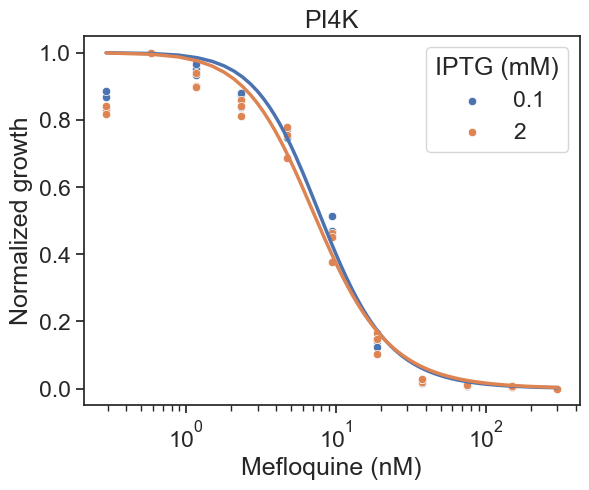

In [937]:
plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[500,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[500,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[500,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[500,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

# ax.set_xlim([0.03, 700])
ax.set_ylim([-0.05, 1.05])

Parameters: [4711.21667078  -27.27366263]
RMSE: 0.10329109987392666
R-squared: 0.9130524816884716
[4711.21667078  -27.27366263]
IC50:  4711.216670780254
Parameters: [4091.82038752  -21.210279  ]
RMSE: 0.13075995838969737
R-squared: 0.8594522764852173
[4091.82038752  -21.210279  ]
IC50:  4091.820387520833
Parameters: [4091.82038752  -21.210279  ]
RMSE: 0.13075995838969737
R-squared: 0.8594522764852173
[4091.82038752  -21.210279  ]
IC50:  4091.820387520833
Parameters: [4711.21667078  -27.27366263]
RMSE: 0.10329109987392666
R-squared: 0.9130524816884716
[4711.21667078  -27.27366263]
IC50:  4711.216670780254
IC50 fold change: 0.8685273196834652


(-0.05, 1.05)

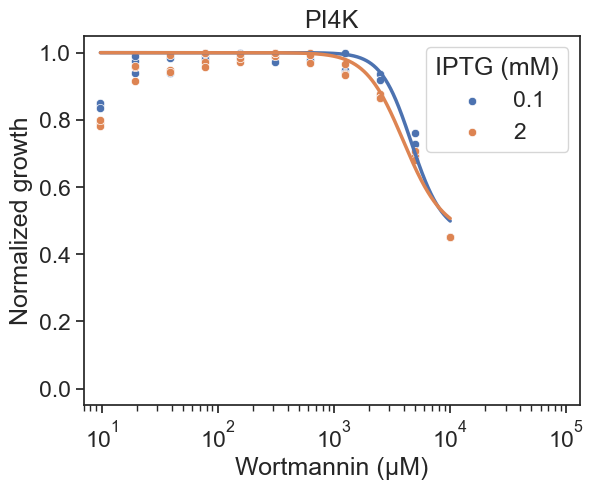

In [918]:
plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1,y=0.45+0.55*y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1,y=0.45+0.55*y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1,y=0.45+0.55*hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1,y=0.45+0.55*hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (µM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([7, 130000])
ax.set_ylim([-0.05, 1.05])

Parameters: [9149.05637204  -22.89567814]
RMSE: 0.03951929897096294
R-squared: 0.9924088155349878
[9149.05637204  -22.89567814]
IC50:  9149.056372043757
Parameters: [10658.19154302   -26.79537712]
RMSE: 0.03200093829926704
R-squared: 0.9953380634453178
[10658.19154302   -26.79537712]
IC50:  10658.191543020945
Parameters: [10658.19154302   -26.79537712]
RMSE: 0.03200093829926704
R-squared: 0.9953380634453178
[10658.19154302   -26.79537712]
IC50:  10658.191543020945
Parameters: [9149.05637204  -22.89567814]
RMSE: 0.03951929897096294
R-squared: 0.9924088155349878
[9149.05637204  -22.89567814]
IC50:  9149.056372043757
IC50 fold change: 1.1649498166377645


/var/folders/89/20dj8qgx0dj2z68d6fcg6_vc0000gn/T/ipykernel_11004/3793797597.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['Treatment'] = compound_name
/var/folders/89/20dj8qgx0dj2z68d6fcg6_vc0000gn/T/ipykernel_11004/3793797597.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['IPTG_nM'] = inducer_concentrations[0]
/var/folders/89/20dj8qgx0dj2z68d6fcg6_vc0000gn/T/ipykernel_11004/3793797597.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

(-0.05, 1.05)

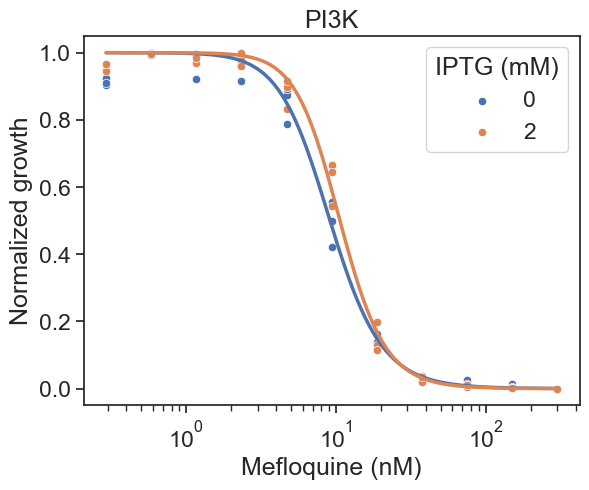

In [5]:
dat_full = pd.read_csv('./127 mq 129 wort kdu 27 Nov/127 mq Rluc 15sec shake 1sec int 2023.11.27 15_15_20.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI3K'#'PI3K'#'PI4K'
inducer_concentrations = [0,2]#[ 0.5,2 ]
compound_name = 'Mefloquine'#'Wortmannin'#'KDU691'
compound_concentration_max = 300000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[500,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[500,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[500,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[500,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

# ax.set_xlim([0.03, 700])
ax.set_ylim([-0.05, 1.05])

Parameters: [2163.38121719   -8.65890766]
RMSE: 0.06390150136820621
R-squared: 0.970904436714507
[2163.38121719   -8.65890766]
IC50:  2163.3812171908057
Parameters: [10144.56487903   -11.8998795 ]
RMSE: 0.04860726931162717
R-squared: 0.9856495958321692
[10144.56487903   -11.8998795 ]
IC50:  10144.564879033565
Parameters: [10144.56487903   -11.8998795 ]
RMSE: 0.04860726931162717
R-squared: 0.9856495958321692
[10144.56487903   -11.8998795 ]
IC50:  10144.564879033565
Parameters: [2163.38121719   -8.65890766]
RMSE: 0.06390150136820621
R-squared: 0.970904436714507
[2163.38121719   -8.65890766]
IC50:  2163.3812171908057
IC50 fold change: 4.68921741504555


(-0.05, 1.05)

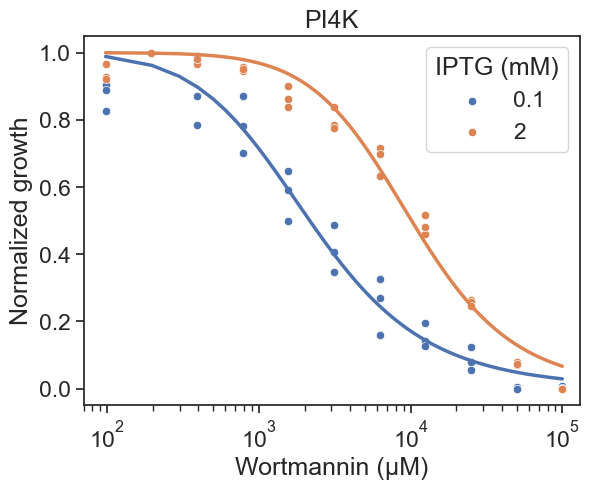

In [54]:
dat_full = pd.read_csv('./127 mq 129 wort kdu 27 Nov/129 wort Rluc 15sec shake 1sec int 2023.11.27 15_27_47.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI4K'#'PI3K'#'PI4K'
inducer_concentrations = [0.1,2]#[ 0.5,2 ]
compound_name = 'Wortmannin'#'KDU691'
compound_concentration_max = 100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (µM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([70, 130000])
ax.set_ylim([-0.05, 1.05])

Parameters: [642.09171098  -9.51352571]
RMSE: 0.05665357674017486
R-squared: 0.9772826352735414
[642.09171098  -9.51352571]
IC50:  642.091710980812
Parameters: [2038.31321747  -16.83766348]
RMSE: 0.05018957726406284
R-squared: 0.9887960800286397
[2038.31321747  -16.83766348]
IC50:  2038.3132174732582
Parameters: [2038.31321747  -16.83766348]
RMSE: 0.05018957726406284
R-squared: 0.9887960800286397
[2038.31321747  -16.83766348]
IC50:  2038.3132174732582
Parameters: [642.09171098  -9.51352571]
RMSE: 0.05665357674017486
R-squared: 0.9772826352735414
[642.09171098  -9.51352571]
IC50:  642.091710980812
IC50 fold change: 3.1744892242257436


(-0.05, 1.05)

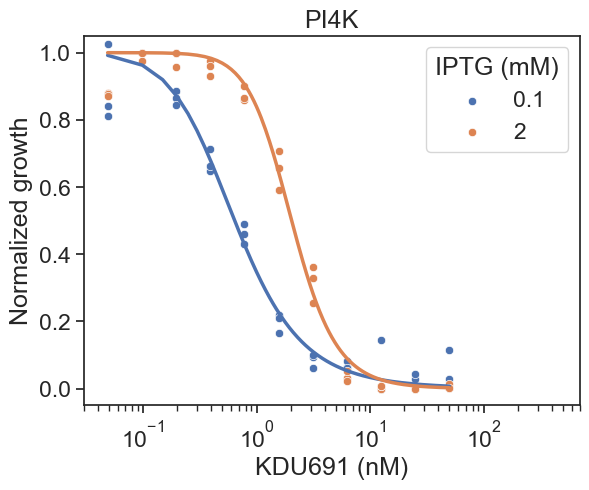

In [48]:
dat_full = pd.read_csv('./127 mq 129 wort kdu 27 Nov/129 kdu Rluc 15sec shake 1sec int 2023.11.27 15_38_35.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI4K'#'PI3K'#'PI4K'
inducer_concentrations = [0.1,2]#[ 0.5,2 ]
compound_name = 'KDU691'
compound_concentration_max = 50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([0.03, 700])
ax.set_ylim([-0.05, 1.05])

Parameters: [15817.62506521   -42.21942924]
RMSE: 0.038085742170103104
R-squared: 0.9938657115006095
[15817.62506521   -42.21942924]
IC50:  15817.625065206765
Parameters: [17363.94477006   -65.61726479]
RMSE: 0.04872987262977868
R-squared: 0.9908400639285192
[17363.94477006   -65.61726479]
IC50:  17363.944770059472
Parameters: [17363.94477006   -65.61726479]
RMSE: 0.04872987262977868
R-squared: 0.9908400639285192
[17363.94477006   -65.61726479]
IC50:  17363.944770059472
Parameters: [15817.62506521   -42.21942924]
RMSE: 0.038085742170103104
R-squared: 0.9938657115006095
[15817.62506521   -42.21942924]
IC50:  15817.625065206765
IC50 fold change: 1.0977592842464112


(-0.05, 1.05)

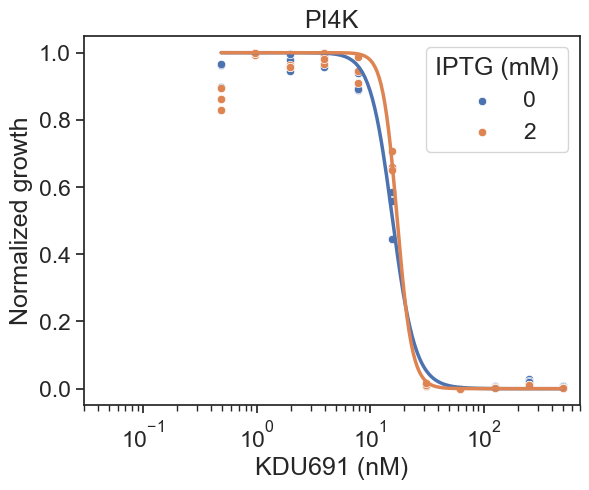

In [49]:
dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 127 kdu Rluc 15sec shake 1sec int 2023.11.12 22_53_28.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI3K'#'PI3K'#'PI4K'
inducer_concentrations = [0,2]#[ 0.5,2 ]
compound_name = 'KDU691'
compound_concentration_max = 500000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([0.03, 700])
ax.set_ylim([-0.05, 1.05])

Parameters: [2708.4346811    -8.71440048]
RMSE: 0.04877362151435629
R-squared: 0.9836269286151942
[2708.4346811    -8.71440048]
IC50:  2708.4346810993948
Parameters: [8165.30929223  -12.00584556]
RMSE: 0.052341994826723436
R-squared: 0.9846200986977683
[8165.30929223  -12.00584556]
IC50:  8165.309292232217
Parameters: [8165.30929223  -12.00584556]
RMSE: 0.052341994826723436
R-squared: 0.9846200986977683
[8165.30929223  -12.00584556]
IC50:  8165.309292232217
Parameters: [2708.4346811    -8.71440048]
RMSE: 0.04877362151435629
R-squared: 0.9836269286151942
[2708.4346811    -8.71440048]
IC50:  2708.4346810993948
IC50 fold change: 3.0147706161101855


(-0.05, 1.05)

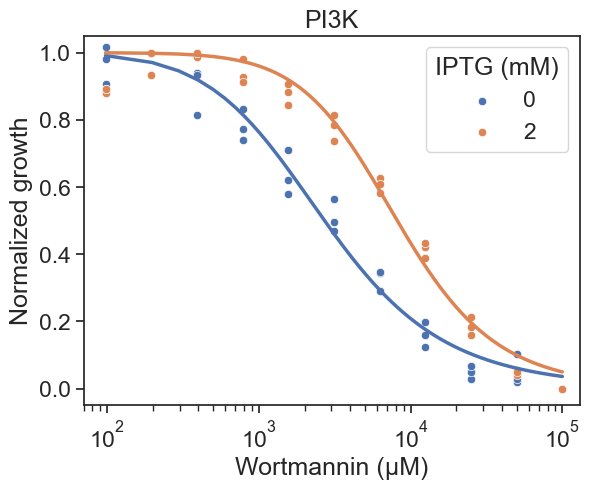

In [9]:
dat_full = pd.read_csv('./Pablo PI3K PI4K 7Nov2023/pablo wort Rluc 15sec shake 1sec int 2023.11.07 15_58_32 rm outlier.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI3K'#'PI3K'#'PI4K'
inducer_concentrations = [0,2]#[ 0.5,2 ]
compound_name = 'Wortmannin'#'KDU691'
compound_concentration_max = 100000#100000#50000
compound_rows_no_inducer = ['A','B','C']
compound_rows_inducer = ['D','E','F']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (µM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([70, 130000])
ax.set_ylim([-0.05, 1.05])

Parameters: [3187.20511797  -11.45800953]
RMSE: 0.03888927510184881
R-squared: 0.9910318852657902
[3187.20511797  -11.45800953]
IC50:  3187.2051179699292
Parameters: [4751.76075072   -9.73048174]
RMSE: 0.05958851744013909
R-squared: 0.9774355168936337
[4751.76075072   -9.73048174]
IC50:  4751.760750719203
Parameters: [4751.76075072   -9.73048174]
RMSE: 0.05958851744013909
R-squared: 0.9774355168936337
[4751.76075072   -9.73048174]
IC50:  4751.760750719203
Parameters: [3187.20511797  -11.45800953]
RMSE: 0.03888927510184881
R-squared: 0.9910318852657902
[3187.20511797  -11.45800953]
IC50:  3187.2051179699292
IC50 fold change: 1.4908863957101726


(-0.05, 1.05)

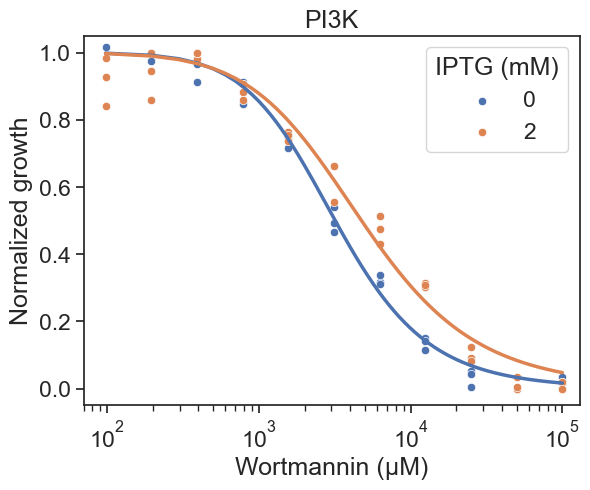

In [6]:
dat_full = pd.read_csv('./127 129 wort 30 nov/127 wort Rluc 15sec shake 1sec int 2023.11.30 15_28_37.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI3K'#'PI3K'#'PI4K'
inducer_concentrations = [0,2]#[ 0.5,2 ]
compound_name = 'Wortmannin'#'KDU691'
compound_concentration_max = 100000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (µM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([70, 130000])
ax.set_ylim([-0.05, 1.05])

Parameters: [1826.96869052  -11.17716673]
RMSE: 0.042886521151923436
R-squared: 0.9887530415791451
[1826.96869052  -11.17716673]
IC50:  1826.9686905246263
Parameters: [3686.23168746  -11.11166036]
RMSE: 0.05885914429011461
R-squared: 0.9799716343223595
[3686.23168746  -11.11166036]
IC50:  3686.2316874588546
Parameters: [3686.23168746  -11.11166036]
RMSE: 0.05885914429011461
R-squared: 0.9799716343223595
[3686.23168746  -11.11166036]
IC50:  3686.2316874588546
Parameters: [1826.96869052  -11.17716673]
RMSE: 0.042886521151923436
R-squared: 0.9887530415791451
[1826.96869052  -11.17716673]
IC50:  1826.9686905246263
IC50 fold change: 2.017676442172815


(-0.05, 1.05)

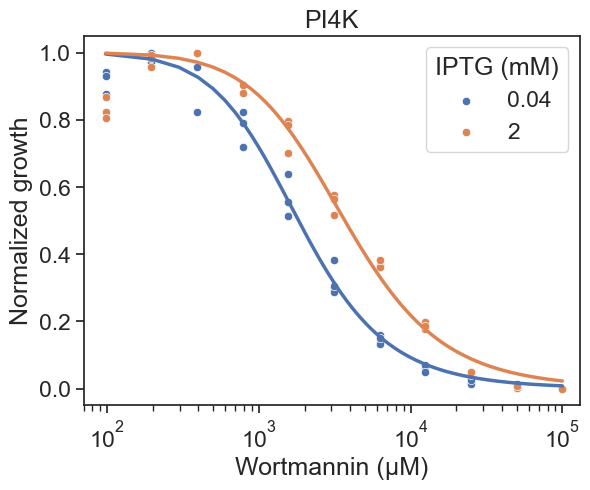

In [10]:
dat_full = pd.read_csv('./127 129 wort 30 nov/129 wort Rluc 15sec shake 1sec int 2023.11.30 15_41_57.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI4K'#'PI3K'#'PI4K'
inducer_concentrations = [0.04,2]#[ 0.5,2 ]
compound_name = 'Wortmannin'#'KDU691'
compound_concentration_max = 100000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (µM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([70, 130000])
ax.set_ylim([-0.05, 1.05])

Parameters: [14682.09303337   -17.62971425]
RMSE: 0.056123441681936274
R-squared: 0.9847814404491535
[14682.09303337   -17.62971425]
IC50:  14682.093033371708
Parameters: [18542.39305701   -31.71949595]
RMSE: 0.04756586790840828
R-squared: 0.9906651791097915
[18542.39305701   -31.71949595]
IC50:  18542.393057008587
Parameters: [18542.39305701   -31.71949595]
RMSE: 0.04756586790840828
R-squared: 0.9906651791097915
[18542.39305701   -31.71949595]
IC50:  18542.393057008587
Parameters: [14682.09303337   -17.62971425]
RMSE: 0.056123441681936274
R-squared: 0.9847814404491535
[14682.09303337   -17.62971425]
IC50:  14682.093033371708
IC50 fold change: 1.2629257296532994


(-0.05, 1.05)

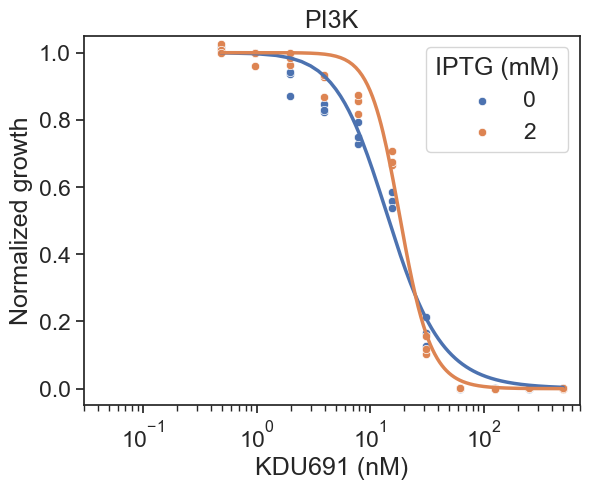

In [6]:
dat_full = pd.read_csv('./13 dec 2023/127 kdu Rluc 15sec shake 1sec int 2023.12.13 18_01_12.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI3K'#'PI3K'#'PI4K'
inducer_concentrations = [0,2]#[ 0.5,2 ]
compound_name = 'KDU691'
compound_concentration_max = 500000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([0.03, 700])
ax.set_ylim([-0.05, 1.05])

Parameters: [ 72.74828189 -15.05607457]
RMSE: 0.05650054053834762
R-squared: 0.9832361435477136
[ 72.74828189 -15.05607457]
IC50:  72.74828189454632
Parameters: [ 39.83619266 -23.35722351]
RMSE: 14.763932616748264
R-squared: 0.022752736034000076
[ 39.83619266 -23.35722351]
IC50:  39.83619266478201
Parameters: [ 39.83619266 -23.35722351]
RMSE: 14.763932616748264
R-squared: 0.022752736034000076
[ 39.83619266 -23.35722351]
IC50:  39.83619266478201
Parameters: [ 72.74828189 -15.05607457]
RMSE: 0.05650054053834762
R-squared: 0.9832361435477136
[ 72.74828189 -15.05607457]
IC50:  72.74828189454632
IC50 fold change: 0.5475894636594626


(-0.05, 1.05)

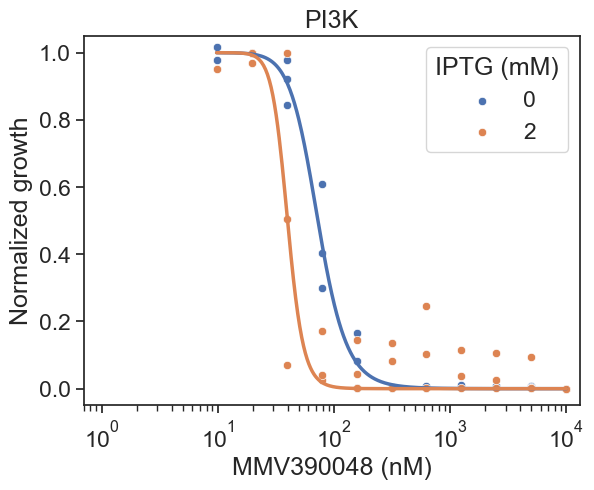

In [22]:
dat_full = pd.read_csv('./13 dec 2023/127 mmv390048 Rluc 15sec shake 1sec int 2023.12.13 18_14_00.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI3K'#'PI3K'#'PI4K'
inducer_concentrations = [0,2]#[ 0.5,2 ]
compound_name = 'MMV390048'#'KDU691'
compound_concentration_max = 10000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e4)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[1000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[1000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[1000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[1000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([0.7, 13000])
ax.set_ylim([-0.05, 1.05])

Parameters: [6973.25676917  -18.07705749]
RMSE: 0.03730212874671513
R-squared: 0.9928558112480503
[6973.25676917  -18.07705749]
IC50:  6973.256769167883
Parameters: [6381.44205362  -20.17227803]
RMSE: 0.0368003617982519
R-squared: 0.9934522718965315
[6381.44205362  -20.17227803]
IC50:  6381.442053624969
Parameters: [6381.44205362  -20.17227803]
RMSE: 0.0368003617982519
R-squared: 0.9934522718965315
[6381.44205362  -20.17227803]
IC50:  6381.442053624969
Parameters: [6973.25676917  -18.07705749]
RMSE: 0.03730212874671513
R-squared: 0.9928558112480503
[6973.25676917  -18.07705749]
IC50:  6973.256769167883
IC50 fold change: 0.9151308011258654


(-0.05, 1.05)

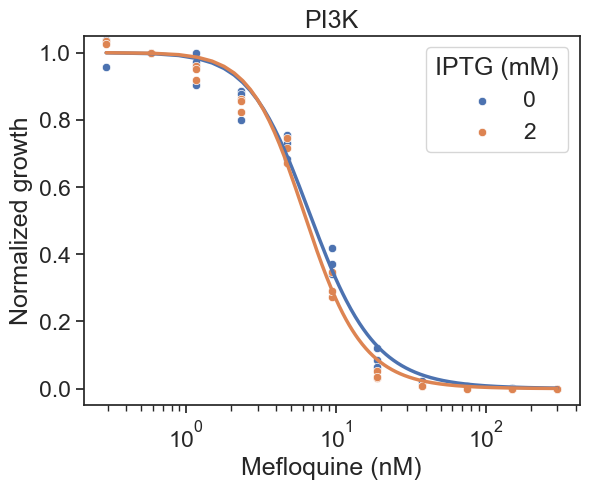

In [19]:
dat_full = pd.read_csv('./13 dec 2023/127 mq Rluc 15sec shake 1sec int 2023.12.13 18_23_34.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI3K'#'PI3K'#'PI4K'
inducer_concentrations = [0,2]#[ 0.5,2 ]
compound_name = 'Mefloquine'#'Wortmannin'#'KDU691'
compound_concentration_max = 300000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[500,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[500,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[500,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[500,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

# ax.set_xlim([0.03, 700])
ax.set_ylim([-0.05, 1.05])

Parameters: [2165.91713624   -9.45428703]
RMSE: 0.03467128077866397
R-squared: 0.9923516043107196
[2165.91713624   -9.45428703]
IC50:  2165.9171362443667
Parameters: [10979.94420145   -12.39864802]
RMSE: 0.04868400434419509
R-squared: 0.9852179565587385
[10979.94420145   -12.39864802]
IC50:  10979.944201452086
Parameters: [10979.94420145   -12.39864802]
RMSE: 0.04868400434419509
R-squared: 0.9852179565587385
[10979.94420145   -12.39864802]
IC50:  10979.944201452086
Parameters: [2165.91713624   -9.45428703]
RMSE: 0.03467128077866397
R-squared: 0.9923516043107196
[2165.91713624   -9.45428703]
IC50:  2165.9171362443667
IC50 fold change: 5.069420255149267


(-0.05, 1.05)

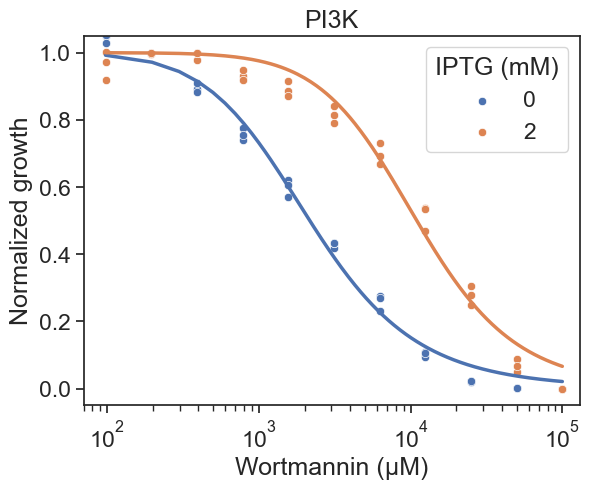

In [20]:
dat_full = pd.read_csv('./13 dec 2023/127 wort Rluc 15sec shake 1sec int 2023.12.13 18_08_00.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI3K'#'PI3K'#'PI4K'
inducer_concentrations = [0,2]#[ 0.5,2 ]
compound_name = 'Wortmannin'#'KDU691'
compound_concentration_max = 100000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (µM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([70, 130000])
ax.set_ylim([-0.05, 1.05])

Parameters: [567.00926125 -11.51893935]
RMSE: 0.03460493691980481
R-squared: 0.993224834631509
[567.00926125 -11.51893935]
IC50:  567.0092612464671
Parameters: [1300.54516338  -13.81620113]
RMSE: 0.042354437509434795
R-squared: 0.9921606625689942
[1300.54516338  -13.81620113]
IC50:  1300.545163379118
Parameters: [1300.54516338  -13.81620113]
RMSE: 0.042354437509434795
R-squared: 0.9921606625689942
[1300.54516338  -13.81620113]
IC50:  1300.545163379118
Parameters: [567.00926125 -11.51893935]
RMSE: 0.03460493691980481
R-squared: 0.993224834631509
[567.00926125 -11.51893935]
IC50:  567.0092612464671
IC50 fold change: 2.2936929822276717


(-0.05, 1.05)

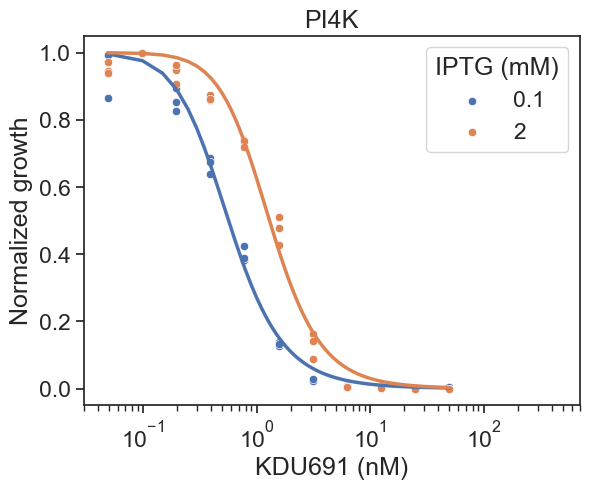

In [23]:
dat_full = pd.read_csv('./13 dec 2023/129 kdu Rluc 15sec shake 1sec int 2023.12.13 18_29_14.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI4K'#'PI3K'#'PI4K'
inducer_concentrations = [0.1,2]#[ 0.5,2 ]
compound_name = 'KDU691'
compound_concentration_max = 50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1000,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1000,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([0.03, 700])
ax.set_ylim([-0.05, 1.05])

Parameters: [ 32.9624794  -37.90811473]
RMSE: 0.5861793629298693
R-squared: 0.4423933820462602
[ 32.9624794  -37.90811473]
IC50:  32.962479397482234
Parameters: [ 32.60049659 -19.60244087]
RMSE: 0.21291233322107792
R-squared: 0.7011599042407722
[ 32.60049659 -19.60244087]
IC50:  32.60049658792526
Parameters: [ 32.60049659 -19.60244087]
RMSE: 0.21291233322107792
R-squared: 0.7011599042407722
[ 32.60049659 -19.60244087]
IC50:  32.60049658792526
Parameters: [ 32.9624794  -37.90811473]
RMSE: 0.5861793629298693
R-squared: 0.4423933820462602
[ 32.9624794  -37.90811473]
IC50:  32.962479397482234
IC50 fold change: 0.9890183379353246


(-0.05, 1.05)

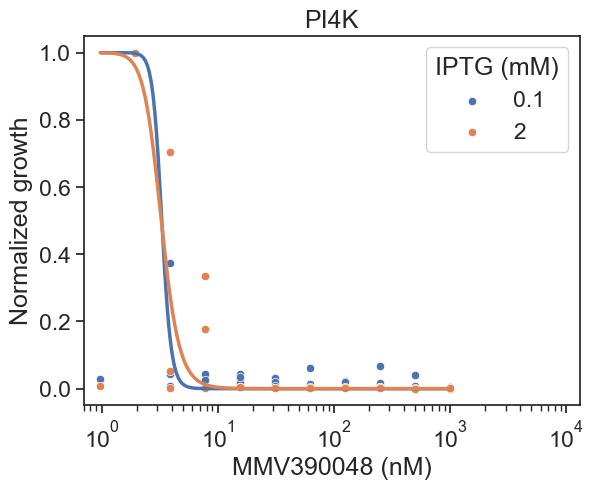

In [38]:
dat_full = pd.read_csv('./13 dec 2023/129 mmv390048 Rluc 15sec shake 1sec int 2023.12.13 18_42_31.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI4K'#'PI3K'#'PI4K'
inducer_concentrations = [0.1,2]#[ 0.5,2 ]
compound_name = 'MMV390048'#'KDU691'
compound_concentration_max = 10000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e4)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/10,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/10,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/10,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[1000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/10,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[1000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[1000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[1000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([0.7, 13000])
ax.set_ylim([-0.05, 1.05])

Parameters: [5470.74733286  -10.22494392]
RMSE: 0.056038916245466176
R-squared: 0.9799982367446528
[5470.74733286  -10.22494392]
IC50:  5470.747332856873
Parameters: [6306.2364381   -10.68616216]
RMSE: 0.03872450170788684
R-squared: 0.9909516637134822
[6306.2364381   -10.68616216]
IC50:  6306.236438101085
Parameters: [6306.2364381   -10.68616216]
RMSE: 0.03872450170788684
R-squared: 0.9909516637134822
[6306.2364381   -10.68616216]
IC50:  6306.236438101085
Parameters: [5470.74733286  -10.22494392]
RMSE: 0.056038916245466176
R-squared: 0.9799982367446528
[5470.74733286  -10.22494392]
IC50:  5470.747332856873
IC50 fold change: 1.1527193734988144


(-0.05, 1.05)

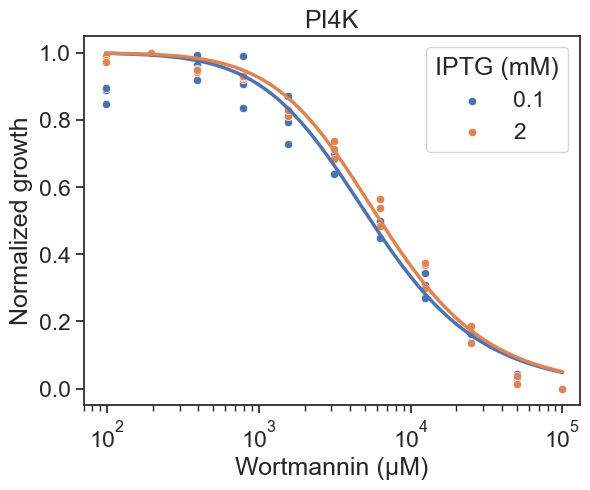

In [39]:
dat_full = pd.read_csv('./13 dec 2023/129 wort Rluc 15sec shake 1sec int 2023.12.13 18_35_17.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI4K'#'PI3K'#'PI4K'
inducer_concentrations = [0.1,2]#[ 0.5,2 ]
compound_name = 'Wortmannin'#'KDU691'
compound_concentration_max = 100000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e3)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/1,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[10000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/1,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[10000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[10000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[10000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (µM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([70, 130000])
ax.set_ylim([-0.05, 1.05])

Parameters: [143.59674127 -14.53238939]
RMSE: 0.050928762487191366
R-squared: 0.9877252592023279
[143.59674127 -14.53238939]
IC50:  143.59674127012727
Parameters: [156.14092101 -19.83391744]
RMSE: 0.04148669239441831
R-squared: 0.9922972049552403
[156.14092101 -19.83391744]
IC50:  156.14092100524104
Parameters: [156.14092101 -19.83391744]
RMSE: 0.04148669239441831
R-squared: 0.9922972049552403
[156.14092101 -19.83391744]
IC50:  156.14092100524104
Parameters: [143.59674127 -14.53238939]
RMSE: 0.050928762487191366
R-squared: 0.9877252592023279
[143.59674127 -14.53238939]
IC50:  143.59674127012727
IC50 fold change: 1.0873569944844101


(-0.05, 1.05)

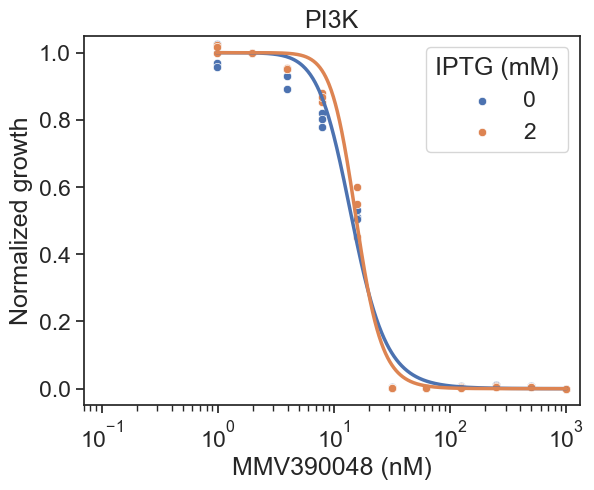

In [20]:
dat_full = pd.read_csv('./127 129 MMV390048 16 Jan 2024/127 mmv390048 Rluc 15sec shake 1sec int 2024.01.16 19_33_27.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI3K'#'PI3K'#'PI4K'
inducer_concentrations = [0,2]#[ 0.5,2 ]
compound_name = 'MMV390048'#'KDU691'
compound_concentration_max = 10000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e4)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/10,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/10,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/10,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[1000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/10,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[1000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[1000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[1000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([0.07, 1300])
ax.set_ylim([-0.05, 1.05])

Parameters: [71.43312612 -8.9310839 ]
RMSE: 0.028872079299887082
R-squared: 0.9948373706975967
[71.43312612 -8.9310839 ]
IC50:  71.4331261188064
Parameters: [164.16397042 -12.93983278]
RMSE: 0.03280166309998083
R-squared: 0.9951957405985687
[164.16397042 -12.93983278]
IC50:  164.16397042105694
Parameters: [164.16397042 -12.93983278]
RMSE: 0.03280166309998083
R-squared: 0.9951957405985687
[164.16397042 -12.93983278]
IC50:  164.16397042105694
Parameters: [71.43312612 -8.9310839 ]
RMSE: 0.028872079299887082
R-squared: 0.9948373706975967
[71.43312612 -8.9310839 ]
IC50:  71.4331261188064
IC50 fold change: 2.2981490428967386


(-0.05, 1.05)

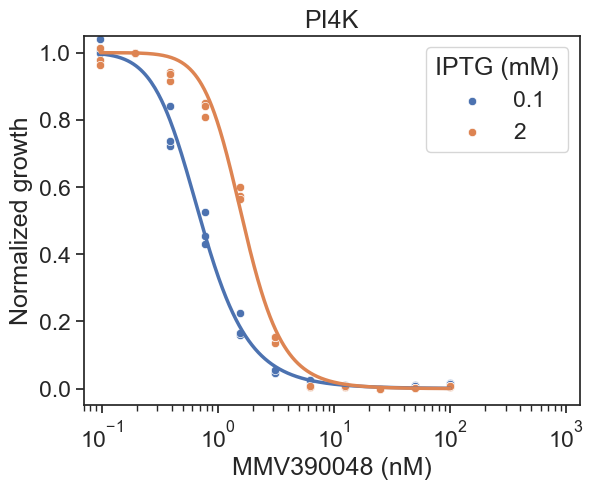

In [21]:
dat_full = pd.read_csv('./127 129 MMV390048 16 Jan 2024/129 mmv390048 Rluc 15sec shake 1sec int 2024.01.16 19_45_05.csv')

dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
dat_full['Column'] = pd.to_numeric(dat_full['Column'])

dat_full

gene_name = 'PI4K'#'PI3K'#'PI4K'
inducer_concentrations = [0.1,2]#[ 0.5,2 ]
compound_name = 'MMV390048'#'KDU691'
compound_concentration_max = 10000#100000#50000
compound_rows_no_inducer = ['B','C','D']
compound_rows_inducer = ['E','F','G']
dilution_factor = 2
num_dilutions = 11
compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

dat['Treatment'] = compound_name
# dat.loc[ ( dat['Column'].isin([1,24]) ),'Treatment' ] = 'DHA'
dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

dat['IPTG_nM'] = inducer_concentrations[0]
dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

dat

dat['Fraction_growth'] = 0

for row in compound_rows_no_inducer+compound_rows_inducer:
    dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )

dat

plot_var = 'Fraction_growth'
# plot_var = 'RLU'

n_points_hill = int(1e4)
x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

x_compound = np.array(compound_concentrations*3)
y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var], label = inducer_concentrations[0], color=palette[0]) 
ax = sns.scatterplot(x=x_compound/100,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
# ax = sns.lineplot(x=compound_concentrations,y=dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),].groupby(['Column'])[[plot_var]].agg('mean')[plot_var].iloc[::-1] , label = inducer_concentrations[1], color=palette[1]) 
ax = sns.scatterplot(x=x_compound/100,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

ax = sns.lineplot(x=x_hill/100,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=[1000,10]) ), color=palette[0]) 
ax = sns.lineplot(x=x_hill/100,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=[1000,10]) ), color=palette[1]) 
# ax = sns.lineplot(x=x_hill,y=hillFunc( x_hill,5e4,5e0 ), label = inducer_concentrations[0], color=palette[1]) 

IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=[1000,10])[0] / fitHill(x_compound,y_inducer_0,initial_parameters=[1000,10])[0]
print('IC50 fold change:',IC50_fold_change)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title='IPTG (mM)')
ax.set_title(gene_name)
ax.set_xlabel(compound_name+' (nM)')
ax.set_ylabel('Normalized growth')

ax.set_xlim([0.07, 1300])
ax.set_ylim([-0.05, 1.05])

In [1]:
import numpy as np # handle arrays
import pandas as pd # data wrangling
import matplotlib.pyplot as plt # plots
import seaborn as sns # pretty plots

from scipy.optimize import curve_fit
import warnings

sns.set_theme(style="ticks",font_scale = 1.5,rc={"lines.linewidth": 2.5})

palette = sns.color_palette()

In [2]:
def hillFunc(x, K, h): # Hill sigmoidal equation from zunzun.com
    return np.power(np.log10(x), h) / (np.power(np.log10(K), h) + np.power(np.log10(x), h))

def fitHill(x,y,func=hillFunc,initial_parameters=np.array([500, 10])):
    # these are the same as the scipy defaults

    # do not print unnecessary warnings during curve_fit()
    warnings.filterwarnings("ignore")

    # curve fit the test data
    fitted_parameters, pcov = curve_fit(func, x, y, initial_parameters)

    model_predictions = func(x, *fitted_parameters) 

    abs_error = model_predictions - y

    SE = np.square(abs_error) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(abs_error) / np.var(y))

    print('Parameters:', fitted_parameters)
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)
    
    print(fitted_parameters)
    print('IC50: ',fitted_parameters[0])
    
    return fitted_parameters

In [9]:
def plotCurves(
        dat_full=None,
        gene_name=None,
        inducer_concentrations=None,
        compound_name=None,
        compound_concentration_max=None,
        compound_rows_no_inducer=None,
        compound_rows_inducer=None,
        dilution_factor=None,
        num_dilutions=None,
        xlim=None,
        ylim=None,
        fit_scaling_coefficient=None, # these are added because otherwise the curve fitter doesn't converge
        fit_init_param=None, # these are added because otherwise the curve fitter doesn't converge
        units=None
        ):
    
    dat_full[['Row', 'Column']] = dat_full['WellPosition'].str.split(':', n=1, expand=True)
    dat_full['Column'] = pd.to_numeric(dat_full['Column'])
    
    compound_concentrations = [ compound_concentration_max/(dilution_factor**i) for i in range(num_dilutions) ]

    dat = dat_full.loc[ ( dat_full['Row'].isin( compound_rows_no_inducer+compound_rows_inducer ) ) ]

    dat['Treatment'] = compound_name

    dat.loc[ ( dat['Column'].isin([12]) ),'Treatment' ] = 'DMSO'

    dat['IPTG_nM'] = inducer_concentrations[0]
    dat.loc[ ( dat['Row'].isin(compound_rows_inducer) ),'IPTG_nM' ] = inducer_concentrations[1]

    dat['Fraction_growth'] = 0

    for row in compound_rows_no_inducer+compound_rows_inducer:
        dat.loc[ (dat['Row']==row),'Fraction_growth' ] = ( dat.loc[ (dat['Row']==row),'RLU' ] - dat.loc[ (dat['Row']==row),'RLU' ].min() ) / ( dat.loc[ (dat['Row']==row)&(dat['Column']<11),'RLU' ].max() - dat.loc[ (dat['Row']==row),'RLU' ].min() )


    plot_var = 'Fraction_growth'

    n_points_hill = int(1e3)
    x_hill = np.linspace( min(compound_concentrations),max(compound_concentrations),n_points_hill )

    x_compound = np.array(compound_concentrations*3)
    y_inducer_0 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[0]),plot_var ]
    y_inducer_1 = dat.loc[ (dat['Treatment']==compound_name)&(dat['IPTG_nM']==inducer_concentrations[1]),plot_var ]

    ax = sns.scatterplot(x=x_compound/fit_scaling_coefficient,y=y_inducer_0, label = inducer_concentrations[0], color=palette[0])
    ax = sns.scatterplot(x=x_compound/fit_scaling_coefficient,y=y_inducer_1, label = inducer_concentrations[1], color=palette[1])

    ax = sns.lineplot(x=x_hill/fit_scaling_coefficient,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_0,initial_parameters=fit_init_param) ), color=palette[0]) 
    ax = sns.lineplot(x=x_hill/fit_scaling_coefficient,y=hillFunc( x_hill,*fitHill(np.array(x_compound)*1,y_inducer_1,initial_parameters=fit_init_param) ), color=palette[1]) 

    IC50_fold_change = fitHill(x_compound,y_inducer_1,initial_parameters=fit_init_param)[0] / fitHill(x_compound,y_inducer_0,initial_parameters=fit_init_param)[0]
    print('IC50 fold change:',IC50_fold_change)

    ax.set_xscale('log')
    ax.get_legend().remove()
    ax.set_title(gene_name)
    ax.set_xlabel(compound_name+' ('+units+')')
    ax.set_ylabel('Normalized growth')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Parameters: [ 1.49170924e+04 -1.37806572e+01]
RMSE: 0.07042709103850374
R-squared: 0.9676512476733223
[ 1.49170924e+04 -1.37806572e+01]
IC50:  14917.092419782857
Parameters: [ 1.72865365e+04 -1.38062910e+01]
RMSE: 0.0659405027581161
R-squared: 0.9718858470218907
[ 1.72865365e+04 -1.38062910e+01]
IC50:  17286.5364597132
Parameters: [ 1.72865365e+04 -1.38062910e+01]
RMSE: 0.0659405027581161
R-squared: 0.9718858470218907
[ 1.72865365e+04 -1.38062910e+01]
IC50:  17286.5364597132
Parameters: [ 1.49170924e+04 -1.37806572e+01]
RMSE: 0.07042709103850374
R-squared: 0.9676512476733223
[ 1.49170924e+04 -1.37806572e+01]
IC50:  14917.092419782857
IC50 fold change: 1.1588408768446066


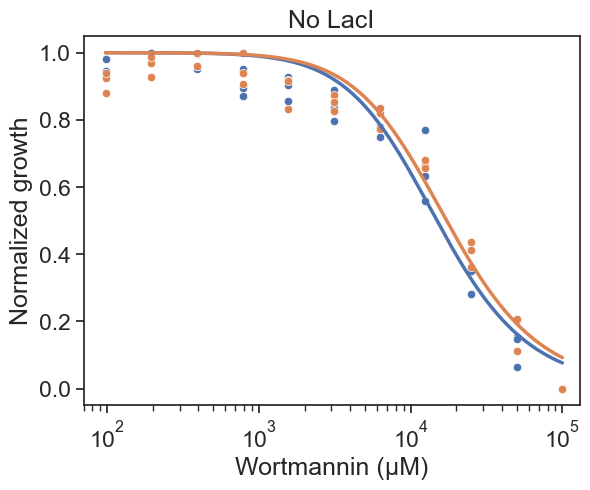

In [10]:
plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/pPC098 wort Rluc 15sec shake 1sec int 2024.01.19 11_53_46.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0,2],
    compound_name = 'Wortmannin',
    compound_concentration_max = 100000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [70, 130000],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1,
    fit_init_param=[10000,10],
    units='µM'
    )

Parameters: [23588.35707929   -47.04376669]
RMSE: 0.1052454412974828
R-squared: 0.9504170837388912
[23588.35707929   -47.04376669]
IC50:  23588.35707928554
Parameters: [19148.87382881   -71.77033074]
RMSE: 0.05680536646439595
R-squared: 0.9879020380535055
[19148.87382881   -71.77033074]
IC50:  19148.873828806823
Parameters: [19148.87382881   -71.77033074]
RMSE: 0.05680536646439595
R-squared: 0.9879020380535055
[19148.87382881   -71.77033074]
IC50:  19148.873828806823
Parameters: [23588.35707929   -47.04376669]
RMSE: 0.1052454412974828
R-squared: 0.9504170837388912
[23588.35707929   -47.04376669]
IC50:  23588.35707928554
IC50 fold change: 0.811793452356319


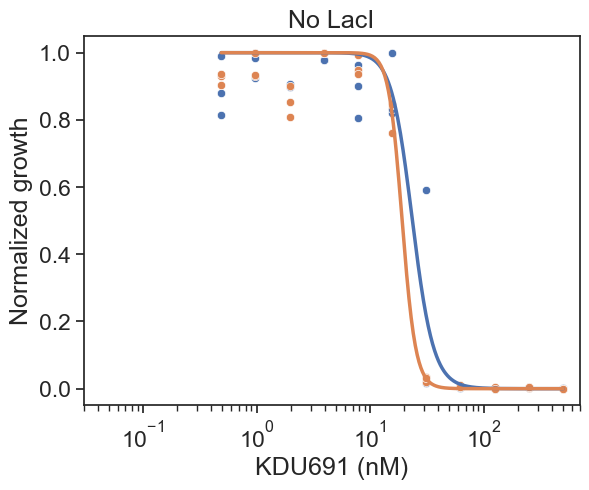

In [12]:
plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/ppc098 kdu Rluc 15sec shake 1sec int 2024.02.08 19_21_32.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0,2],
    compound_name = 'KDU691',
    compound_concentration_max = 500000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 700],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[10000,10],
    units='nM'
    )

Parameters: [361.54922617 -40.23993365]
RMSE: 0.07147953047771524
R-squared: 0.9788935843041013
[361.54922617 -40.23993365]
IC50:  361.54922617107303
Parameters: [381.63164623 -43.76426532]
RMSE: 0.05682033374851571
R-squared: 0.9878978023004371
[381.63164623 -43.76426532]
IC50:  381.6316462258027
Parameters: [381.63164623 -43.76426532]
RMSE: 0.05682033374851571
R-squared: 0.9878978023004371
[381.63164623 -43.76426532]
IC50:  381.6316462258027
Parameters: [361.54922617 -40.23993365]
RMSE: 0.07147953047771524
R-squared: 0.9788935843041013
[361.54922617 -40.23993365]
IC50:  361.54922617107303
IC50 fold change: 1.0555454654609808


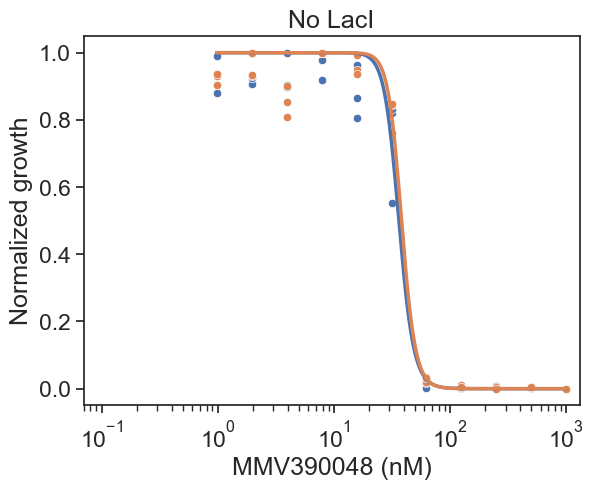

In [15]:
plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/ppc098 kdu Rluc 15sec shake 1sec int 2024.02.08 19_21_32.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0,2],
    compound_name = 'MMV390048',
    compound_concentration_max = 10000,
    compound_rows_no_inducer = ['B','C','A'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.07, 1300],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=10,
    fit_init_param=[1000,10],
    units='nM'
    )

Parameters: [5765.36179379  -25.47733161]
RMSE: 0.059754026099966565
R-squared: 0.9810727485040809
[5765.36179379  -25.47733161]
IC50:  5765.361793789395
Parameters: [5224.10374405  -22.33203303]
RMSE: 0.055163972065557336
R-squared: 0.9859272216909482
[5224.10374405  -22.33203303]
IC50:  5224.103744046097
Parameters: [5224.10374405  -22.33203303]
RMSE: 0.055163972065557336
R-squared: 0.9859272216909482
[5224.10374405  -22.33203303]
IC50:  5224.103744046097
Parameters: [5765.36179379  -25.47733161]
RMSE: 0.059754026099966565
R-squared: 0.9810727485040809
[5765.36179379  -25.47733161]
IC50:  5765.361793789395
IC50 fold change: 0.906118979328174


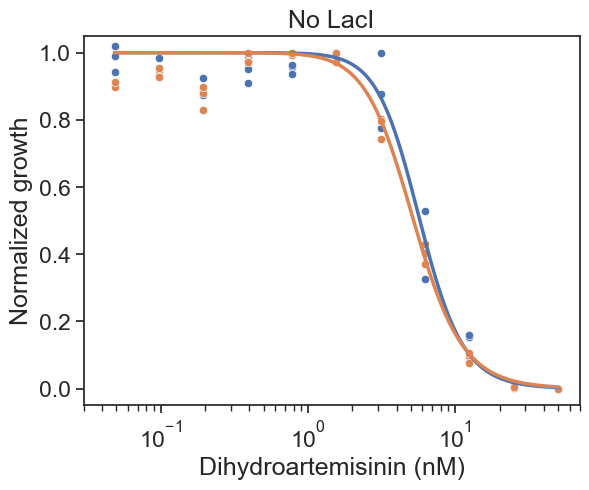

In [19]:
plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/ppc098 dha Rluc 15sec shake 1sec int 2024.02.08 19_34_07.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0,2],
    compound_name = 'Dihydroartemisinin',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 70],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

Parameters: [10943.73853469   -29.98554614]
RMSE: 0.05895883582811189
R-squared: 0.9871894704550473
[10943.73853469   -29.98554614]
IC50:  10943.738534688811
Parameters: [10067.8607026    -33.94344118]
RMSE: 0.04747860866787166
R-squared: 0.9910757660753888
[10067.8607026    -33.94344118]
IC50:  10067.860702596303
Parameters: [10067.8607026    -33.94344118]
RMSE: 0.04747860866787166
R-squared: 0.9910757660753888
[10067.8607026    -33.94344118]
IC50:  10067.860702596303
Parameters: [10943.73853469   -29.98554614]
RMSE: 0.05895883582811189
R-squared: 0.9871894704550473
[10943.73853469   -29.98554614]
IC50:  10943.738534688811
IC50 fold change: 0.9199653912311407


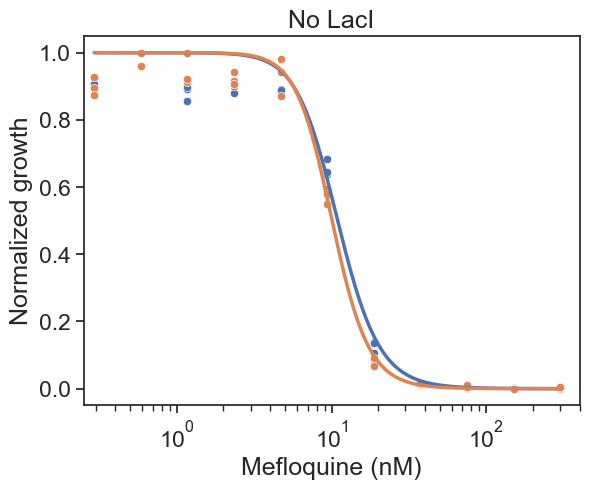

In [20]:
plotCurves(
    dat_full = pd.read_csv('./pPC098 No LacI/ppc098 mq Rluc 15sec shake 1sec int 2024.02.08 19_39_21.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0,2],
    compound_name = 'Mefloquine',
    compound_concentration_max = 300000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.25, 400],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

In [ ]:
# Now PI3K cKD line:

Parameters: [2165.91713624   -9.45428703]
RMSE: 0.03467128077866397
R-squared: 0.9923516043107196
[2165.91713624   -9.45428703]
IC50:  2165.9171362443667
Parameters: [10979.94420145   -12.39864802]
RMSE: 0.04868400434419509
R-squared: 0.9852179565587385
[10979.94420145   -12.39864802]
IC50:  10979.944201452086
Parameters: [10979.94420145   -12.39864802]
RMSE: 0.04868400434419509
R-squared: 0.9852179565587385
[10979.94420145   -12.39864802]
IC50:  10979.944201452086
Parameters: [2165.91713624   -9.45428703]
RMSE: 0.03467128077866397
R-squared: 0.9923516043107196
[2165.91713624   -9.45428703]
IC50:  2165.9171362443667
IC50 fold change: 5.069420255149267


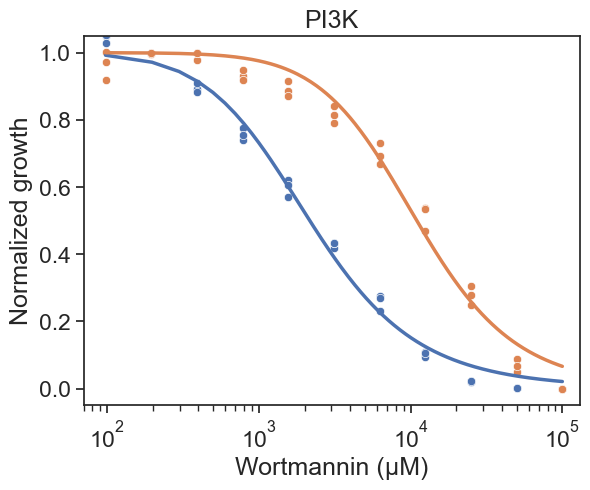

In [25]:
plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/127 wort Rluc 15sec shake 1sec int 2023.12.13 18_08_00.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'Wortmannin',
    compound_concentration_max = 100000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [70, 130000],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1,
    fit_init_param=[10000,10],
    units='µM'
    )

Parameters: [15817.62506521   -42.21942924]
RMSE: 0.038085742170103104
R-squared: 0.9938657115006095
[15817.62506521   -42.21942924]
IC50:  15817.625065206765
Parameters: [17363.94477006   -65.61726479]
RMSE: 0.04872987262977868
R-squared: 0.9908400639285192
[17363.94477006   -65.61726479]
IC50:  17363.944770059472
Parameters: [17363.94477006   -65.61726479]
RMSE: 0.04872987262977868
R-squared: 0.9908400639285192
[17363.94477006   -65.61726479]
IC50:  17363.944770059472
Parameters: [15817.62506521   -42.21942924]
RMSE: 0.038085742170103104
R-squared: 0.9938657115006095
[15817.62506521   -42.21942924]
IC50:  15817.625065206765
IC50 fold change: 1.0977592842464112


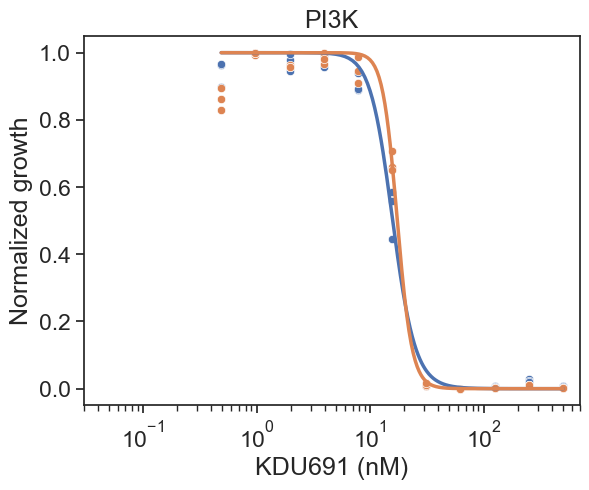

In [26]:
plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/pablo 127 kdu Rluc 15sec shake 1sec int 2023.11.12 22_53_28.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'KDU691',
    compound_concentration_max = 500000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 700],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[10000,10],
    units='nM'
    )

Parameters: [143.59674127 -14.53238939]
RMSE: 0.050928762487191366
R-squared: 0.9877252592023279
[143.59674127 -14.53238939]
IC50:  143.59674127012727
Parameters: [156.14092101 -19.83391744]
RMSE: 0.04148669239441831
R-squared: 0.9922972049552403
[156.14092101 -19.83391744]
IC50:  156.14092100524104
Parameters: [156.14092101 -19.83391744]
RMSE: 0.04148669239441831
R-squared: 0.9922972049552403
[156.14092101 -19.83391744]
IC50:  156.14092100524104
Parameters: [143.59674127 -14.53238939]
RMSE: 0.050928762487191366
R-squared: 0.9877252592023279
[143.59674127 -14.53238939]
IC50:  143.59674127012727
IC50 fold change: 1.0873569944844101


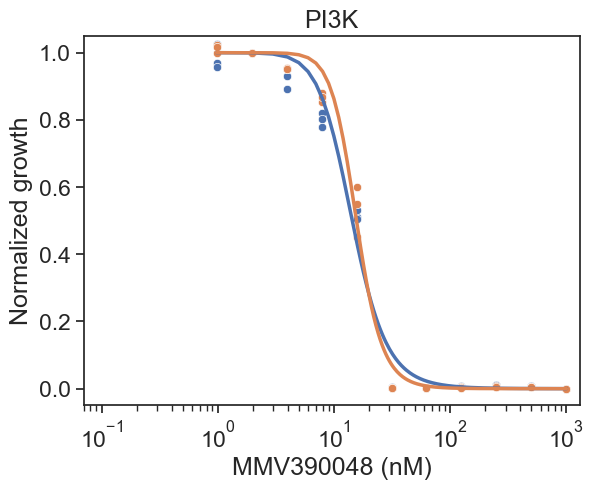

In [33]:
plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/127 mmv390048 Rluc 15sec shake 1sec int 2024.01.16 19_33_27.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'MMV390048',
    compound_concentration_max = 10000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.07, 1300],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=10,
    fit_init_param=[1000,10],
    units='nM'
    )

Parameters: [3870.98812619  -14.48487586]
RMSE: 0.0479417109224142
R-squared: 0.9895934376718241
[3870.98812619  -14.48487586]
IC50:  3870.9881261922046
Parameters: [4431.58813611  -14.75582108]
RMSE: 0.06744624235268162
R-squared: 0.9762413908483062
[4431.58813611  -14.75582108]
IC50:  4431.588136106856
Parameters: [4431.58813611  -14.75582108]
RMSE: 0.06744624235268162
R-squared: 0.9762413908483062
[4431.58813611  -14.75582108]
IC50:  4431.588136106856
Parameters: [3870.98812619  -14.48487586]
RMSE: 0.0479417109224142
R-squared: 0.9895934376718241
[3870.98812619  -14.48487586]
IC50:  3870.9881261922046
IC50 fold change: 1.1448209066107624


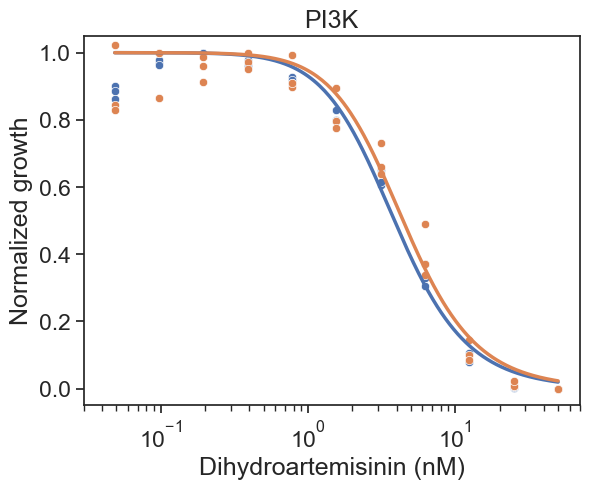

In [43]:
plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/pablo 127 dha Rluc 15sec shake 1sec int 2023.11.12 22_08_41.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'Dihydroartemisinin',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','H','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 70],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

Parameters: [9149.05637204  -22.89567814]
RMSE: 0.03951929897096294
R-squared: 0.9924088155349878
[9149.05637204  -22.89567814]
IC50:  9149.056372043757
Parameters: [10658.19154302   -26.79537712]
RMSE: 0.03200093829926704
R-squared: 0.9953380634453178
[10658.19154302   -26.79537712]
IC50:  10658.191543020945
Parameters: [10658.19154302   -26.79537712]
RMSE: 0.03200093829926704
R-squared: 0.9953380634453178
[10658.19154302   -26.79537712]
IC50:  10658.191543020945
Parameters: [9149.05637204  -22.89567814]
RMSE: 0.03951929897096294
R-squared: 0.9924088155349878
[9149.05637204  -22.89567814]
IC50:  9149.056372043757
IC50 fold change: 1.1649498166377645


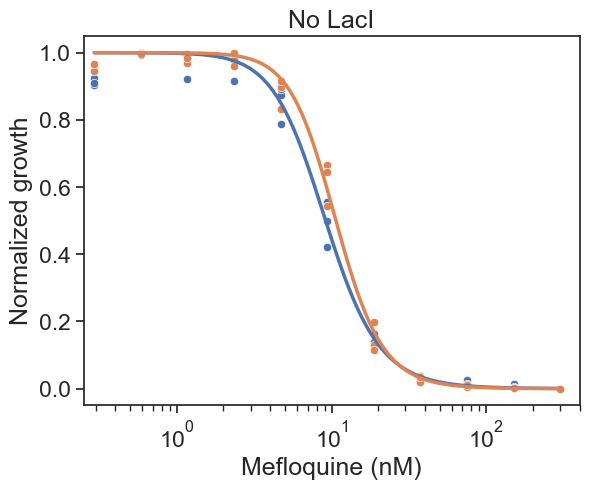

In [29]:
plotCurves(
    dat_full = pd.read_csv('./pPC127 PI3K/127 mq Rluc 15sec shake 1sec int 2023.11.27 15_15_20.csv'),
    gene_name = 'PI3K',
    inducer_concentrations = [0,2],
    compound_name = 'Mefloquine',
    compound_concentration_max = 300000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.25, 400],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

In [ ]:
# Now PI4K cKD:

Parameters: [5470.74733286  -10.22494392]
RMSE: 0.056038916245466176
R-squared: 0.9799982367446528
[5470.74733286  -10.22494392]
IC50:  5470.747332856873
Parameters: [6306.2364381   -10.68616216]
RMSE: 0.03872450170788684
R-squared: 0.9909516637134822
[6306.2364381   -10.68616216]
IC50:  6306.236438101085
Parameters: [6306.2364381   -10.68616216]
RMSE: 0.03872450170788684
R-squared: 0.9909516637134822
[6306.2364381   -10.68616216]
IC50:  6306.236438101085
Parameters: [5470.74733286  -10.22494392]
RMSE: 0.056038916245466176
R-squared: 0.9799982367446528
[5470.74733286  -10.22494392]
IC50:  5470.747332856873
IC50 fold change: 1.1527193734988144


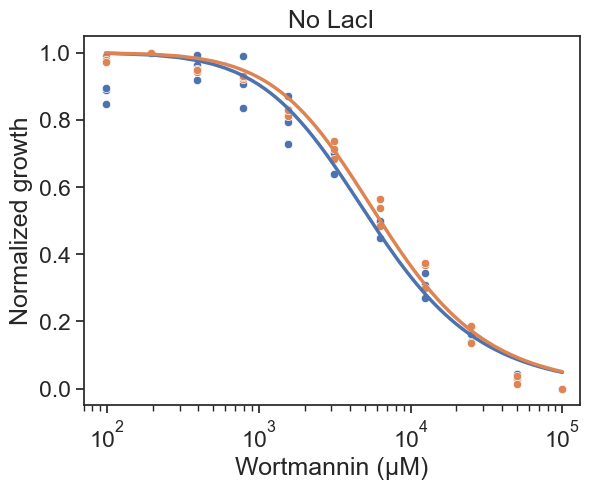

In [24]:
plotCurves(
    dat_full = pd.read_csv('./pPC129 PI4K/129 wort Rluc 15sec shake 1sec int 2023.12.13 18_35_17.csv'),
    gene_name = 'No LacI',
    inducer_concentrations = [0.1,2],
    compound_name = 'Wortmannin',
    compound_concentration_max = 100000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [70, 130000],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1,
    fit_init_param=[10000,10],
    units='µM'
    )

Parameters: [642.09171098  -9.51352571]
RMSE: 0.05665357674017486
R-squared: 0.9772826352735414
[642.09171098  -9.51352571]
IC50:  642.091710980812
Parameters: [2038.31321747  -16.83766348]
RMSE: 0.05018957726406284
R-squared: 0.9887960800286397
[2038.31321747  -16.83766348]
IC50:  2038.3132174732582
Parameters: [2038.31321747  -16.83766348]
RMSE: 0.05018957726406284
R-squared: 0.9887960800286397
[2038.31321747  -16.83766348]
IC50:  2038.3132174732582
Parameters: [642.09171098  -9.51352571]
RMSE: 0.05665357674017486
R-squared: 0.9772826352735414
[642.09171098  -9.51352571]
IC50:  642.091710980812
IC50 fold change: 3.1744892242257436


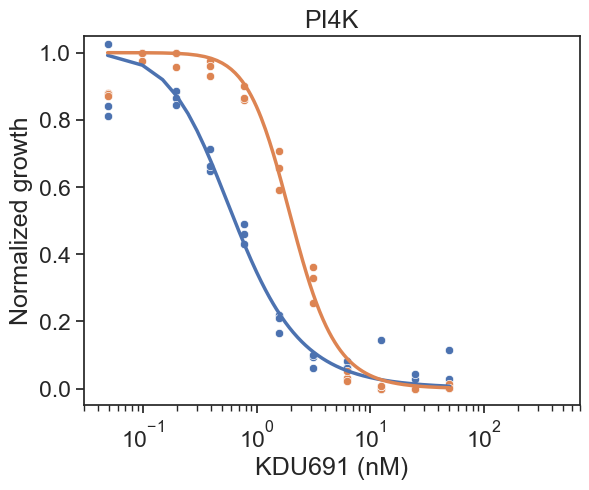

In [28]:
plotCurves(
    dat_full = pd.read_csv('./pPC129 PI4K/129 kdu Rluc 15sec shake 1sec int 2023.11.27 15_38_35.csv'),
    gene_name = 'PI4K',
    inducer_concentrations = [0.04,2],
    compound_name = 'KDU691',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 700],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[10000,10],
    units='nM'
    )

Parameters: [71.43312612 -8.9310839 ]
RMSE: 0.028872079299887082
R-squared: 0.9948373706975967
[71.43312612 -8.9310839 ]
IC50:  71.4331261188064
Parameters: [164.16397042 -12.93983278]
RMSE: 0.03280166309998083
R-squared: 0.9951957405985687
[164.16397042 -12.93983278]
IC50:  164.16397042105694
Parameters: [164.16397042 -12.93983278]
RMSE: 0.03280166309998083
R-squared: 0.9951957405985687
[164.16397042 -12.93983278]
IC50:  164.16397042105694
Parameters: [71.43312612 -8.9310839 ]
RMSE: 0.028872079299887082
R-squared: 0.9948373706975967
[71.43312612 -8.9310839 ]
IC50:  71.4331261188064
IC50 fold change: 2.2981490428967386


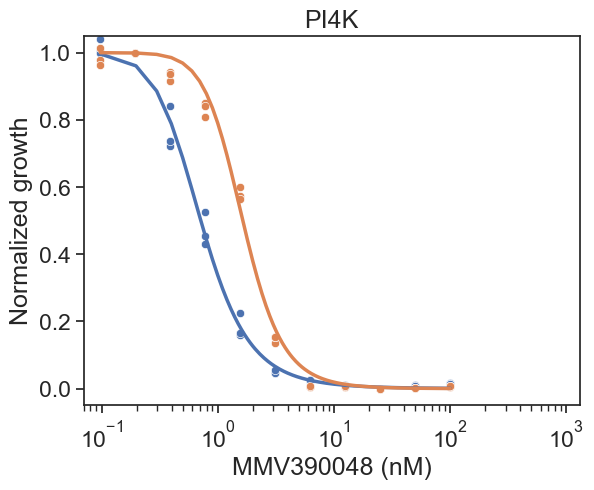

In [22]:
plotCurves(
    dat_full = pd.read_csv('./pPC129 PI4K/129 mmv390048 Rluc 15sec shake 1sec int 2024.01.16 19_45_05.csv'),
    gene_name = 'PI4K',
    inducer_concentrations = [0.1,2],
    compound_name = 'MMV390048',
    compound_concentration_max = 10000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.07, 1300],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=100,
    fit_init_param=[1000,10],
    units='nM'
    )

Parameters: [4810.1549689  -18.6532953]
RMSE: 0.06306410051251143
R-squared: 0.9797538001591289
[4810.1549689  -18.6532953]
IC50:  4810.154968898488
Parameters: [4159.5330993   -18.69446992]
RMSE: 0.10491503501848043
R-squared: 0.9427421055501977
[4159.5330993   -18.69446992]
IC50:  4159.533099299597
Parameters: [4159.5330993   -18.69446992]
RMSE: 0.10491503501848043
R-squared: 0.9427421055501977
[4159.5330993   -18.69446992]
IC50:  4159.533099299597
Parameters: [4810.1549689  -18.6532953]
RMSE: 0.06306410051251143
R-squared: 0.9797538001591289
[4810.1549689  -18.6532953]
IC50:  4810.154968898488
IC50 fold change: 0.864739935863671


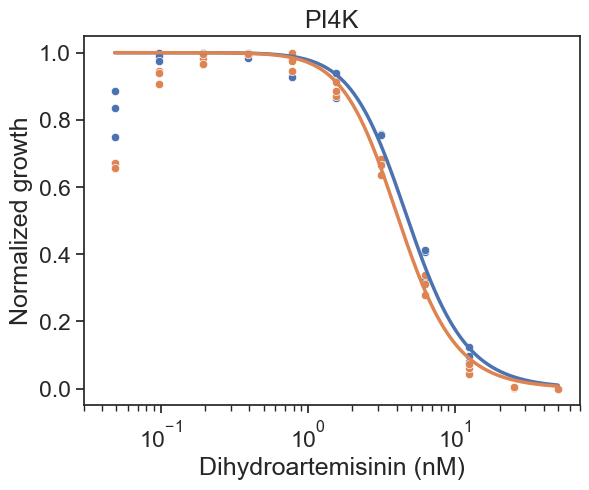

In [35]:
plotCurves(
    dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 129 dha Rluc 15sec shake 1sec int 2023.11.12 23_03_55.csv'),
    gene_name = 'PI4K',
    inducer_concentrations = [0,2],
    compound_name = 'Dihydroartemisinin',
    compound_concentration_max = 50000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.03, 70],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )

Parameters: [8117.10178726  -17.42821464]
RMSE: 0.05359580582148378
R-squared: 0.9867625664517367
[8117.10178726  -17.42821464]
IC50:  8117.101787262806
Parameters: [7472.69804466  -15.99185208]
RMSE: 0.06536294602077282
R-squared: 0.9787044060947473
[7472.69804466  -15.99185208]
IC50:  7472.698044657382
Parameters: [7472.69804466  -15.99185208]
RMSE: 0.06536294602077282
R-squared: 0.9787044060947473
[7472.69804466  -15.99185208]
IC50:  7472.698044657382
Parameters: [8117.10178726  -17.42821464]
RMSE: 0.05359580582148378
R-squared: 0.9867625664517367
[8117.10178726  -17.42821464]
IC50:  8117.101787262806
IC50 fold change: 0.9206115976497166


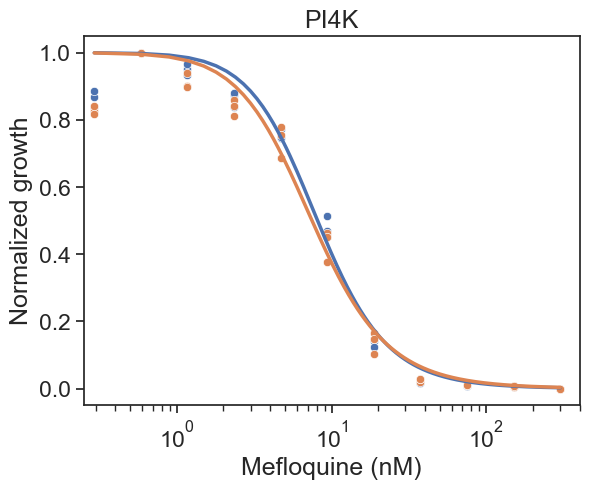

In [32]:
plotCurves(
    dat_full = pd.read_csv('./pablo pi3k pi4k 12 nov/pablo 129 mq Rluc 15sec shake 1sec int 2023.11.12 22_20_00.csv'),
    gene_name = 'PI4K',
    inducer_concentrations = [0.04,2],
    compound_name = 'Mefloquine',
    compound_concentration_max = 300000,
    compound_rows_no_inducer = ['B','C','D'],
    compound_rows_inducer = ['E','F','G'],
    dilution_factor = 2,
    num_dilutions = 11,
    xlim = [0.25, 400],
    ylim = [-0.05, 1.05],
    fit_scaling_coefficient=1000,
    fit_init_param=[500,10],
    units='nM'
    )